# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:

# import libraries here; add more as necessary
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import random
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None


# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
#azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';', dtype={18:'str',19:'str'})
#customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18:'str',19:'str'})

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
customers.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
#drop extra columns from customer dataset
customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3
5,143888,1,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,...,4.0,1.0,2.0,1.0,6.0,9.0,1.0,2,1,3
6,143904,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,4.0,3.0,4.0,2.0,6.0,9.0,7.0,1,1,4
7,143910,1,1.0,10.0,NaN,NaN,NaN,NaN,9.0,1.0,...,3.0,1.0,2.0,1.0,6.0,9.0,3.0,3,1,4
8,102160,2,3.0,5.0,NaN,NaN,NaN,NaN,4.0,74.0,...,NaN,8.0,11.0,9.0,6.0,3.0,4.0,3,2,4
9,102173,1,1.0,20.0,NaN,NaN,NaN,NaN,13.0,1.0,...,2.0,3.0,5.0,4.0,2.0,9.0,5.0,1,1,3


In [7]:
#concat both the datasets
df=pd.concat([azdias,customers])

# Start cleaning the data


In [8]:
null_list = azdias.isnull().sum()
null_per = null_list / len(azdias) * 100

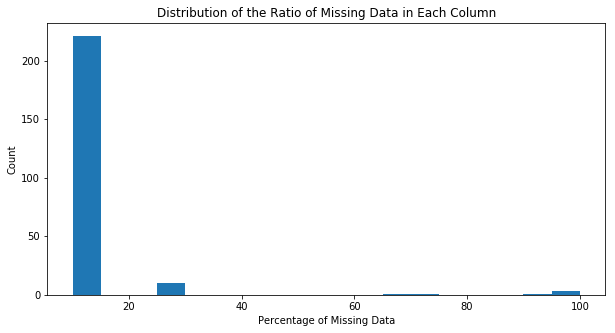

In [9]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(10,5))
plt.title('Distribution of the Ratio of Missing Data in Each Column')
plt.hist(null_per, bins = np.linspace(10,100,19))
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Count')
plt.show()

In [10]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [10]:
customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3
5,143888,1,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,...,4.0,1.0,2.0,1.0,6.0,9.0,1.0,2,1,3
6,143904,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,4.0,3.0,4.0,2.0,6.0,9.0,7.0,1,1,4
7,143910,1,1.0,10.0,NaN,NaN,NaN,NaN,9.0,1.0,...,3.0,1.0,2.0,1.0,6.0,9.0,3.0,3,1,4
8,102160,2,3.0,5.0,NaN,NaN,NaN,NaN,4.0,74.0,...,NaN,8.0,11.0,9.0,6.0,3.0,4.0,3,2,4
9,102173,1,1.0,20.0,NaN,NaN,NaN,NaN,13.0,1.0,...,2.0,3.0,5.0,4.0,2.0,9.0,5.0,1,1,3


In [11]:
def plot_comparison(column):
    sns.set(style="darkgrid")
    fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
    sns.countplot(x = column, data=azdias, ax=ax1, palette="Set3")
    ax1.set_xlabel('Value')
    ax1.set_title('Distribution of feature in AZDIAS dataset')
    sns.countplot(x = column, data=customers, ax=ax2, palette="Set3")
    ax2.set_xlabel('Value')
    ax2.set_title('Distribution of feature in CUSTOMERS dataset')
    fig.tight_layout()
    plt.show()

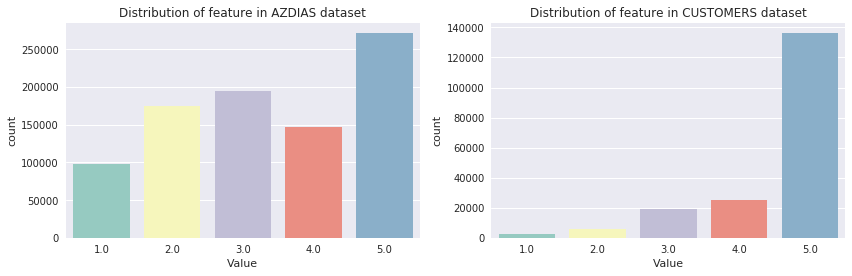

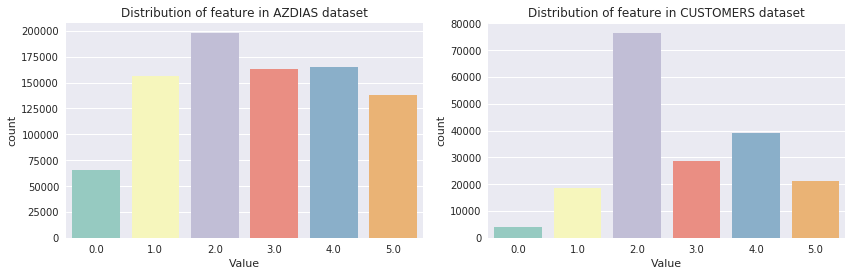

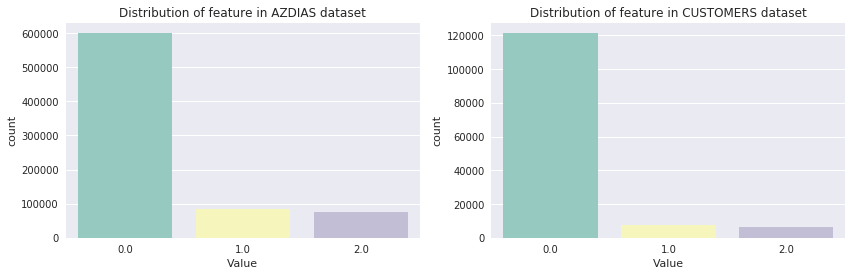

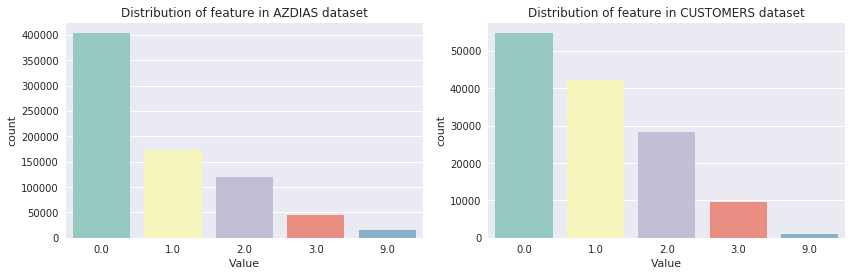

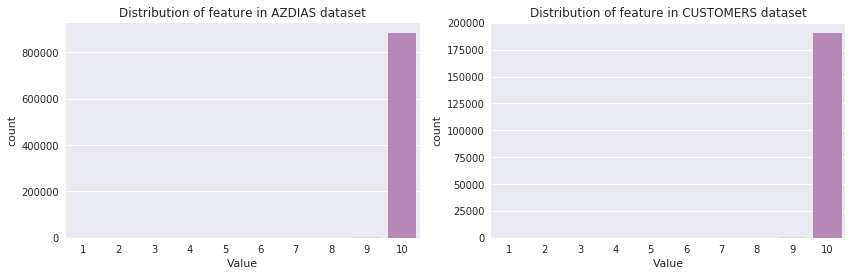

In [12]:
import random
for i in range(5):
    plot_comparison(azdias.columns[random.randint(0, azdias.shape[1])])

In [13]:
%%time
len_azdias, len_customers = len(azdias), len(customers)
# Concat azdias and customers
df = pd.concat([azdias, customers])


CPU times: user 3.18 s, sys: 9.52 s, total: 12.7 s
Wall time: 1min 13s


In [14]:
#apply  cleaning
df.isnull().sum()

AGER_TYP                            0
AKT_DAT_KL                     120095
ALTERSKATEGORIE_FEIN           314789
ALTERSKATEGORIE_GROB                0
ALTER_HH                       120095
ALTER_KIND1                    990049
ALTER_KIND2                   1048274
ALTER_KIND3                   1075428
ALTER_KIND4                   1081432
ANREDE_KZ                           0
ANZ_HAUSHALTE_AKTIV            143075
ANZ_HH_TITEL                   149118
ANZ_KINDER                     120095
ANZ_PERSONEN                   120095
ANZ_STATISTISCHE_HAUSHALTE     143075
ANZ_TITEL                      120095
ARBEIT                         147692
BALLRAUM                       143699
CAMEO_DEUG_2015                149407
CAMEO_DEU_2015                 149407
CAMEO_INTL_2015                149407
CJT_GESAMTTYP                    8067
CJT_KATALOGNUTZER                8067
CJT_TYP_1                        8067
CJT_TYP_2                        8067
CJT_TYP_3                        8067
CJT_TYP_4   

In [15]:
df.dropna(axis=0)

,AGER_TYP,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ALTERSKATEGORIE_GROB,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ANREDE_KZ,...,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
2406,-1,1.0,17.0,2,17.0,12.0,13.0,17.0,18.0,2,...,1,1.0,1.0,2.0,3.0,4.0,9.0,3.0,1.0,4
2781,-1,5.0,14.0,3,16.0,11.0,14.0,16.0,18.0,1,...,2,0.0,3.0,3.0,5.0,3.0,4.0,3.0,1.0,4
4792,-1,1.0,15.0,4,16.0,11.0,11.0,14.0,16.0,1,...,2,2.0,4.0,1.0,1.0,1.0,9.0,2.0,1.0,1
5587,-1,1.0,16.0,1,16.0,3.0,11.0,13.0,13.0,1,...,2,1.0,3.0,3.0,5.0,3.0,9.0,7.0,1.0,4
7220,-1,1.0,15.0,3,16.0,11.0,12.0,13.0,13.0,2,...,1,1.0,1.0,3.0,5.0,4.0,9.0,3.0,1.0,4
8425,-1,1.0,14.0,4,14.0,14.0,14.0,16.0,16.0,2,...,2,1.0,3.0,2.0,3.0,3.0,9.0,2.0,1.0,2
13624,-1,1.0,15.0,3,15.0,14.0,14.0,16.0,16.0,2,...,2,0.0,3.0,3.0,5.0,4.0,9.0,3.0,1.0,4
15865,-1,1.0,17.0,4,18.0,3.0,7.0,7.0,10.0,1,...,1,0.0,1.0,1.0,1.0,1.0,9.0,7.0,1.0,4
17019,2,1.0,12.0,4,18.0,4.0,6.0,6.0,8.0,1,...,1,5.0,3.0,2.0,3.0,3.0,9.0,7.0,1.0,1
17777,-1,5.0,16.0,3,16.0,10.0,10.0,13.0,13.0,1,...,2,0.0,4.0,3.0,5.0,3.0,4.0,1.0,1.0,4


In [16]:
azdias = df[:len_azdias]
customers = df[len_azdias:]

In [17]:
azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ALTERSKATEGORIE_GROB,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ANREDE_KZ,...,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
0,-1,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,1,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,-1,9.0,21.0,1,0.0,NaN,NaN,NaN,NaN,2,...,2,0.0,4.0,8.0,11.0,10.0,9.0,4.0,3.0,5
2,-1,9.0,17.0,3,17.0,NaN,NaN,NaN,NaN,2,...,1,0.0,2.0,9.0,9.0,6.0,9.0,2.0,3.0,5
3,2,1.0,13.0,4,13.0,NaN,NaN,NaN,NaN,2,...,1,1.0,0.0,7.0,10.0,11.0,9.0,7.0,NaN,3
4,-1,1.0,14.0,3,20.0,NaN,NaN,NaN,NaN,1,...,2,0.0,2.0,3.0,5.0,4.0,9.0,3.0,2.0,4


In [ ]:
%%time
# Drop the ID column and do Fit_transform to all the data
azdias.fillna(0, inplace=True)
scale = StandardScaler()
azdias[azdias.columns] = scale.fit_transform(azdias)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [ ]:
%%time
pca = PCA(260)
df_pca = pca.fit_transform(azdias)
scree_plot(pca)

In [ ]:
%%time
pca = PCA(260)
df_pca = pca.fit_transform(azdias)
scree_plot(pca)

In [ ]:

def print_weights(n):
    '''
    n: number of principal component
    '''
    components = pd.DataFrame(np.round(pca.components_[n - 1: n], 4), columns = azdias.keys())
    components.index = ['Weights']
    components = components.sort_values(by = 'Weights', axis = 1, ascending=False)
    components = components.T
    print(components)
    return components

In [ ]:
components_1 = print_weights(1)

In [ ]:
def score(data, k):
    kmeans_k = KMeans(k)
    model_k = kmeans_k.fit(data)
    return abs(model_k.score(data))

In [ ]:
len(scores)

In [ ]:
centers = np.linspace(1,21,21)
centers

In [ ]:
%%time
scores = []
for i in range(1, 21):
    scores.append(score(df_pca[:20000], i))
centers = np.linspace(1,20,20)
plt.plot(centers, scores, linestyle='-', marker='o', color='orange')

In [ ]:
centers = np.linspace(1,20,20)
plt.figure(figsize=(10,6))
plt.plot(centers, scores, linestyle='-', marker='o', color='orange')
plt.xticks(list(range(1,22,2)))
plt.ylabel('Average Within-Cluster Distances')
plt.xlabel('Number of Clusters')

In [ ]:
centers = np.linspace(1,20,20)
plt.figure(figsize=(8, 6))
plt.plot(centers[-15:], scores[-15:], linestyle='-', marker='o', color='orange')

plt.ylabel('Average Within-Cluster Distances')
plt.xlabel('Number of Clusters')

In [ ]:
%%time
kmeans_k = KMeans(12)
model_k = kmeans_k.fit(df_pca)
prediction_azdias = model_k.predict(df_pca)

In [ ]:
def plot_distribution(df, column, height):
    ncount = len(df)
    plt.figure(figsize=(14,6))
    sns.set(style="darkgrid")
    ax = sns.countplot(x = column, data = df)
    plt.title('Distribution of each Cluster')
    plt.xlabel('Cluster Tag')

    # Make twin axis
    ax2=ax.twinx()

    # Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    # Also switch the labels over
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Frequency [%]')

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    # Use a LinearLocator to ensure the correct number of ticks
    ax.yaxis.set_major_locator(ticker.LinearLocator(11))

    # Fix the frequency range to 0-100
    ratio = 100 / height
    ax2.set_ylim(0,100 / ratio)
    ax.set_ylim(0,ncount / ratio)

    # And use a MultipleLocator to ensure a tick spacing of 10
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

    # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None)

In [ ]:
df_prediction_azdias = pd.DataFrame(prediction_azdias, columns = ['Cluster'])
plot_distribution(df_prediction_azdias, 'Cluster', height = 30)

In [ ]:
customers.fillna(0, inplace=True)
customers[customers.columns] = scale.transform(customers)
customers_pca = pca.transform(customers)
prediction_customers = model_k.predict(customers_pca)

In [ ]:

df_prediction_customers = pd.DataFrame(prediction_customers, columns = ['Cluster'])
plot_distribution(df_prediction_customers, 'Cluster', height = 30)

In [ ]:
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';', dtype={18:'str',19:'str'})
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18:'str',19:'str'})

In [ ]:
def plot_comparison(column):
    sns.set(style="darkgrid")
    fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
    sns.countplot(x = column, data=df_target, ax=ax1, palette="Set3")
    ax1.set_xlabel('Value')
    ax1.set_title('Distribution of target population')
    sns.countplot(x = column, data=df_outside, ax=ax2, palette="Set3")
    ax2.set_xlabel('Value')
    ax2.set_title('Distribution of non-target population')
    fig.tight_layout()
    plt.show()

In [ ]:

# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
target_list = df_prediction_customers[df_prediction_customers['Cluster'] == 6].index
df_target = customers.iloc[target_list]
df_target.head(3)

In [ ]:
outside_list = df_prediction_azdias[df_prediction_azdias['Cluster'] == 1].index
df_outside = azdias.iloc[outside_list]
df_outside.head(3)

In [ ]:
plot_comparison('HH_EINKOMMEN_SCORE')

In [ ]:
plot_comparison('SEMIO_PFLICHT')

In [ ]:
plot_comparison('LP_STATUS_GROB')

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype={18:'str',19:'str'})
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype={18:'str',19:'str'})

In [ ]:
# Get y_train from training data
y_reg = mailout_train['RESPONSE']
del mailout_train['RESPONSE']
len_train, len_test = len(mailout_train), len(mailout_test)
# Concat train and test data
df = pd.concat([mailout_train, mailout_test])

In [ ]:
%%time
# Apply Data Cleaning to the dataset
# Note: clean_data_2 is different from clean_data_1
df = clean_data_Kaggle(df)

In [ ]:
df.head()

In [ ]:
# Split the dataset back to train and test
train_data = df[:len_train]
test_data = df[len_train:]

In [ ]:
# Split the dataset into Train/Validation/Test
X_train, X_test, y_train, y_test = train_test_split(train_data, y_reg, stratify=y_reg, test_size=0.2)

In [ ]:
%%time
# Some basic training use LGBMRegressor
reg = lgb.LGBMRegressor(
            learning_rate=0.001, 
            n_estimators=6000,
            lambda_l2 = 0.1
        )
from sklearn.model_selection import GridSearchCV
clf = lgb.LGBMRegressor(random_state=0)
parameters = {'learning_rate' : [0.01, 0.001],
              'max_depth': [3, 5, 10],
              'n_estimators' : [100, 500, 2000]
             }

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring = 'roc_auc')

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator and predict
best_clf = grid_fit.best_estimator_
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("ROC score on testing data: {:.4f}".format(roc_auc_score(y_test, predictions)))
print("\nOptimized Model\n------")
print("ROC score on testing data: {:.4f}".format(roc_auc_score(y_test, best_predictions)))
print("\n------")
print(grid_fit.best_params_)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
test_preds, importances = training_1(train_data, test_data, y_reg)
print_importances(importances)

In [ ]:
submission = pd.read_csv('Arvato_Capstone_Example_Submission.csv')
submission.RESPONSE = test_preds
submission.to_csv('Test.csv', index=False)

In [ ]:

mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype={18:'str',19:'str'})

In [ ]:
df_target = mailout_train[mailout_train['RESPONSE'] == 1]
df_outside = mailout_train[mailout_train['RESPONSE'] == 0]

In [ ]:
plot_comparison('D19_SOZIALES')